In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Recurrent Neural Networks

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

34731

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 28 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO 

## Data Preparation

We need to create the function that transform the x and y.
In this case we need to:
- x: pad the sequences
- y: one hot encoding

In [4]:
maxlen = max([len(x) for x in x_train])
maxlen

170

In [5]:
from functools import partial

def x_transformer(x_data):
    return partial(tf.keras.preprocessing.sequence.pad_sequences, x_data, maxlen, padding='post')

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [6]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.7)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 28
training size 85510, validation size 36647


In [7]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## Models

We evaluate: 
- CNN
- LSTM and GRU models with dropout, 
- reverse the text order and uses Bidirectional-LSTM 

### CNN

In [8]:
def build_model_cnn(num_words, num_classes, embed_size, dropout=0.2):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Conv1D(64,3, activation='relu')(embed_l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.MaxPooling1D(2)(l)
    l = tf.keras.layers.Conv1D(128,3, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.MaxPooling1D(2)(l)
    l = tf.keras.layers.Conv1D(256,3, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.GlobalMaxPool1D()(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)    
    l = tf.keras.layers.Dense(32, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
cnn_model = build_model_cnn(num_words, num_classes, 100, dropout=0.2)
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 82, 128)           0         
__________

In [10]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('cnn', '64_128_256_128_64')),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
    ]  

In [11]:
cnn_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=25, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/25
669/669 [==============================] - 17s 25ms/step - loss: 2.7973 - acc: 0.1725 - val_loss: 2.4585 - val_acc: 0.2488
Epoch 2/25
669/669 [==============================] - 15s 23ms/step - loss: 2.1426 - acc: 0.3503 - val_loss: 2.3907 - val_acc: 0.2964
Epoch 3/25
669/669 [==============================] - 15s 22ms/step - loss: 1.7547 - acc: 0.4479 - val_loss: 1.7352 - val_acc: 0.4684
Epoch 4/25
669/669 [==============================] - 15s 22ms/step - loss: 1.4908 - acc: 0.5247 - val_loss: 2.1169 - val_acc: 0.3801
Epoch 5/25
669/669 [==============================] - 15s 22ms/step - loss: 1.3181 - acc: 0.5740 - val_loss: 1.4943 - val_acc: 0.5212
Epoch 6/25
669/669 [==============================] - 15s 22ms/step - loss: 1.1893 - acc: 0.6140 - val_loss: 1.2458 - val_acc: 0.5956
Epoch 7/25
669/669 [==============================] - 15s 22ms/step - loss: 1.0988 - acc: 0.6454 - val_loss: 1.3818 - val_acc: 0.5755
Epoch 8/25
669/669 [==============================] - 15s 23ms

### GRU

In [9]:
def build_model_gru(neurons, num_words, num_class, embed_size, dropout, rec_dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(neurons, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=True)
    )(embed_l)
    l = tf.keras.layers.GRU(64, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=False)(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(256, activation='relu')(l)
    l = tf.keras.layers.Dropout(0.3)(l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model 

In [122]:
neurons = 64

gru_model = build_model_rnn(neurons, num_words, num_classes, 100, 0.3, 0.2)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('gru', neurons)),
#     tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ] 

gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170, 128)          63360     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [123]:
import gc
gc.collect()

646

In [124]:
history = gru_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=100, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/100
669/669 [==============================] - 413s 618ms/step - loss: 3.0883 - acc: 0.0925 - val_loss: 2.9330 - val_acc: 0.1510
Epoch 2/100
669/669 [==============================] - 408s 610ms/step - loss: 2.3884 - acc: 0.2781 - val_loss: 1.8939 - val_acc: 0.4187
Epoch 3/100
669/669 [==============================] - 405s 606ms/step - loss: 1.8341 - acc: 0.4216 - val_loss: 1.5080 - val_acc: 0.5216
Epoch 4/100
669/669 [==============================] - 405s 605ms/step - loss: 1.4916 - acc: 0.5141 - val_loss: 1.2631 - val_acc: 0.5853
Epoch 5/100
669/669 [==============================] - 403s 602ms/step - loss: 1.2808 - acc: 0.5751 - val_loss: 1.1018 - val_acc: 0.6337
Epoch 6/100
669/669 [==============================] - 406s 607ms/step - loss: 1.1155 - acc: 0.6244 - val_loss: 1.0155 - val_acc: 0.6620
Epoch 7/100
669/669 [==============================] - 407s 609ms/step - loss: 1.0001 - acc: 0.6608 - val_loss: 0.9769 - val_acc: 0.6824
Epoch 8/100
669/669 [====================

Epoch 46/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4249 - acc: 0.8561 - val_loss: 0.7955 - val_acc: 0.7772
Epoch 47/100
668/669 [============================>.] - ETA: 0s - loss: 0.4259 - acc: 0.8558
Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.6384001360475466e-13.
669/669 [==============================] - 400s 599ms/step - loss: 0.4258 - acc: 0.8559 - val_loss: 0.7981 - val_acc: 0.7774
Epoch 48/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4229 - acc: 0.8563 - val_loss: 0.7962 - val_acc: 0.7774
Epoch 49/100
668/669 [============================>.] - ETA: 0s - loss: 0.4265 - acc: 0.8540
Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.2768002178849846e-14.
669/669 [==============================] - 401s 599ms/step - loss: 0.4264 - acc: 0.8541 - val_loss: 0.7950 - val_acc: 0.7774
Epoch 50/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4237 - acc: 0.8560 - val_loss: 0.7961 - val_

Epoch 84/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4292 - acc: 0.8545 - val_loss: 0.7966 - val_acc: 0.7774
Epoch 85/100
668/669 [============================>.] - ETA: 0s - loss: 0.4243 - acc: 0.8567
Epoch 00085: ReduceLROnPlateau reducing learning rate to 8.589935979235544e-27.
669/669 [==============================] - 401s 599ms/step - loss: 0.4244 - acc: 0.8568 - val_loss: 0.7958 - val_acc: 0.7772
Epoch 86/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4296 - acc: 0.8543 - val_loss: 0.7959 - val_acc: 0.7774
Epoch 87/100
668/669 [============================>.] - ETA: 0s - loss: 0.4271 - acc: 0.8549
Epoch 00087: ReduceLROnPlateau reducing learning rate to 1.7179871342173507e-27.
669/669 [==============================] - 401s 599ms/step - loss: 0.4270 - acc: 0.8549 - val_loss: 0.7968 - val_acc: 0.7772
Epoch 88/100
669/669 [==============================] - 401s 599ms/step - loss: 0.4311 - acc: 0.8546 - val_loss: 0.7963 - val_a

In [8]:
import gc
gc.collect()

3

## LSTM

In [20]:
def build_model_lstm(neurons, num_words, num_class, embed_size, dropout, rec_dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(neurons, activation='relu', dropout=dropout, recurrent_dropout=rec_dropout,
                           return_sequences=False)
    )(embed_l)
    l = tf.keras.layers.Dense(128, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model 

In [21]:
lstm_model = build_model_lstm(64, num_words, num_classes, 30, 0.2, 0.1)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 30)           1041930   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               48640     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3612      
Total params: 1,110,694
Trainable params: 1,110,694
Non-trainable params: 0
_________________________________________________________________


In [22]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('lstm', '64')),
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
    ]  

In [23]:
history = lstm_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=100, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks, workers=10)

Epoch 1/100
669/669 [==============================] - 352s 526ms/step - loss: 2.8205 - acc: 0.1929 - val_loss: 2.2650 - val_acc: 0.3619
Epoch 2/100
669/669 [==============================] - 352s 527ms/step - loss: 2.0761 - acc: 0.3861 - val_loss: 1.7454 - val_acc: 0.4896
Epoch 3/100
669/669 [==============================] - 355s 530ms/step - loss: 1.6931 - acc: 0.4840 - val_loss: 1.4548 - val_acc: 0.5493
Epoch 4/100
669/669 [==============================] - 356s 532ms/step - loss: 1.4302 - acc: 0.5450 - val_loss: 1.2579 - val_acc: 0.5953
Epoch 5/100
669/669 [==============================] - 357s 533ms/step - loss: 1.2816 - acc: 0.5861 - val_loss: 1.1628 - val_acc: 0.6201
Epoch 6/100
669/669 [==============================] - 352s 526ms/step - loss: 1.1683 - acc: 0.6177 - val_loss: 1.0902 - val_acc: 0.6428
Epoch 7/100
669/669 [==============================] - 350s 524ms/step - loss: 1.0851 - acc: 0.6411 - val_loss: 1.0546 - val_acc: 0.6504
Epoch 8/100
669/669 [====================

Here we can see that without any parameter optimization we get best results with CNN 

## Build the final model

the best model is obtained embedding of size 64

In [ ]:
import gc
gc.collect()

In [ ]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [ ]:
model = build_model_cnn(num_words, num_classes, embed_size)
cnn_model.summary()

In [ ]:
history = model.fit_generator(train_generator, train_steps, 8)

## Evaluate on the test set

In [12]:
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen)

In [13]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [14]:
test_predictions = cnn_model.predict(x_test_pad, verbose=1)

30540/30540 [==============================] - 2s 50us/step


In [15]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.6734446627373936
precision  0.692784176461301
recall  0.6734446627373936
f-measure  0.6748695096222287


However, by checking the results on the test set we got lower f-measure than the model trained with vectorized representation. Let's take a step more and plot the results.

### Report the classification result for each class

In [16]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.05      0.01      0.02       158
          1       0.31      0.02      0.03       217
          2       0.77      0.70      0.73       686
          3       0.75      0.67      0.71      2765
          4       0.61      0.66      0.63      1658
          5       0.44      0.48      0.46       289
          6       0.38      0.49      0.43       606
          7       0.24      0.10      0.14       316
          8       0.36      0.68      0.47       669
          9       0.78      0.63      0.70      1432
         10       0.49      0.59      0.54       542
         11       0.48      0.62      0.54       767
         12       0.45      0.73      0.55       985
         13       0.96      0.90      0.93      2718
         14       0.85      0.59      0.70       370
         15       0.97      0.84      0.90      1142
         16       0.84      0.64      0.72      1890
         17       0.55      0.40      0.46   

### Confusion Matrix

In [17]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [18]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


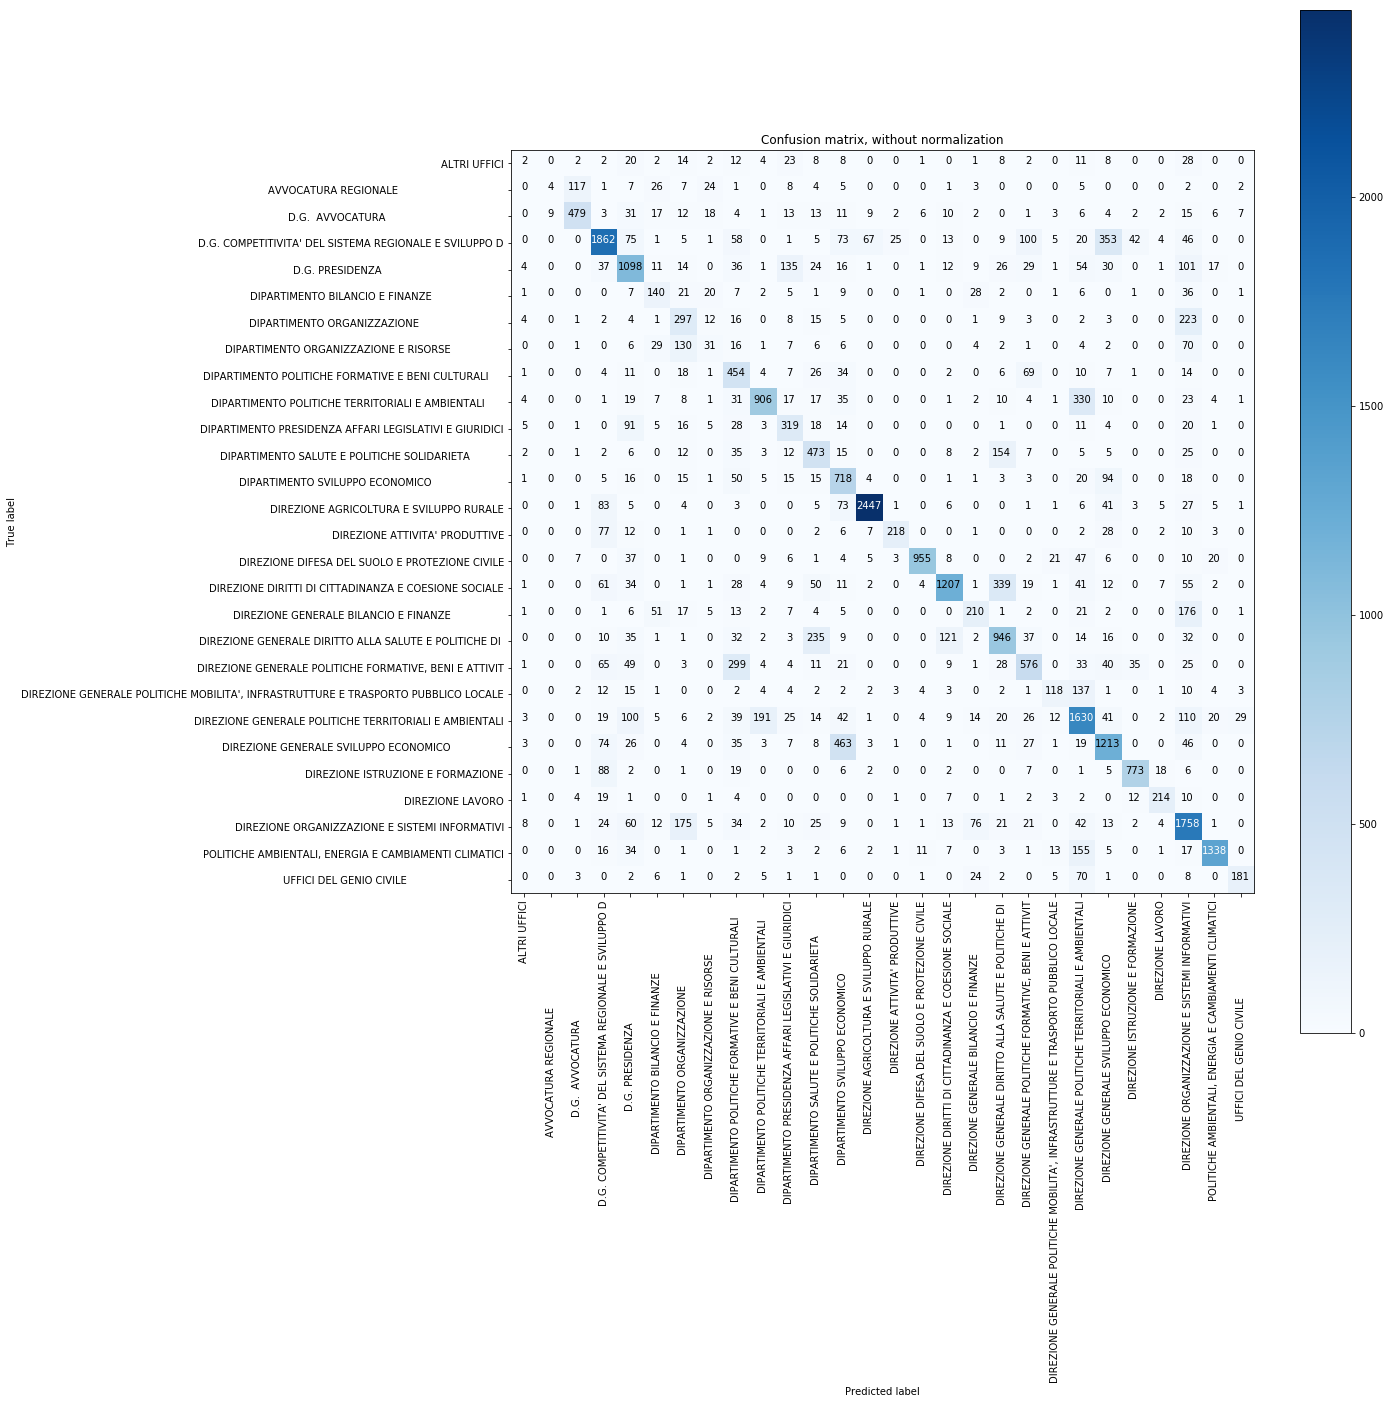

In [19]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')